# Redes neurais feedforward para classificação de câncer de mama

## Etapa 1: Instalando dependências



In [ ]:
!pip install skorch
!pip install pandas
!pip install numpy
!pip install torch
!pip install seaborn
!pip install sklearn
!pip install torch
!pip install ucimlrepo

## Etapa 2: Importanto bibliotecas


In [172]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from skorch import NeuralNetBinaryClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from ucimlrepo import fetch_ucirepo

## Etapa 3: Base de dados

In [ ]:
np.random.seed(123)
torch.manual_seed(123)

In [ ]:
breast_cancer_dataset = fetch_ucirepo(id=17)
X = breast_cancer_dataset.data.features
y = breast_cancer_dataset.data.targets
y['Diagnosis'].replace({'M': 1, 'B': 0}, inplace=True)

In [175]:
X = np.array(X, dtype='float32')
y = np.array(y, dtype='float32')

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train = torch.tensor(np.array(X_train), dtype=torch.float)
y_train = torch.tensor(np.array(y_train), dtype = torch.float)

In [ ]:
X.shape, y.shape

In [178]:
type(X), type(y), type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray, torch.Tensor, torch.Tensor)

## Etapa 4: Preparação do dataset


In [179]:
dataset = torch.utils.data.TensorDataset(X_train, y_train)

In [180]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

## Etapa 3: Arquitetura da rede neural


In [184]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()

    # 30 -> 16 -> 16 -> 1
    self.dense0 = nn.Linear(30, 16)
    torch.nn.init.uniform_(self.dense0.weight)
    self.activation0 = nn.ReLU()
    self.dropout0 = nn.Dropout(0.2)
    self.dense1 = nn.Linear(16, 16)
    torch.nn.init.uniform_(self.dense1.weight)
    self.activation1 = nn.ReLU()
    self.dropout1 = nn.Dropout(0.2)
    self.dense2 = nn.Linear(16, 1)
    torch.nn.init.uniform_(self.dense2.weight)
    self.output = nn.Sigmoid()

  def forward(self, X):
    X = self.dense0(X)
    X = self.activation0(X)
    X = self.dropout0(X)
    X = self.dense1(X)
    X = self.activation1(X)
    X = self.dropout1(X)
    X = self.dense2(X)
    X = self.output(X)
    return X

## Etapa 5: Treinamento da rede neural


In [185]:
classifier = NeuralNetwork()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, weight_decay=0.0001)

In [186]:
def training(train_loader, optimizer, classifier, criterion):
  for epoch in range(100):
    running_loss = 0.

    for data in train_loader:
      inputs, labels = data
      optimizer.zero_grad()
      outputs = classifier.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    print('Época %3d: perda %.5f' % (epoch+1, running_loss/len(train_loader)))

In [187]:
train = training(train_loader, optimizer, classifier, criterion)

Época   1: perda 62.79070
Época   2: perda 62.94574
Época   3: perda 62.79070
Época   4: perda 62.79070
Época   5: perda 63.25581
Época   6: perda 62.79070
Época   7: perda 62.94574
Época   8: perda 63.10078
Época   9: perda 62.79070
Época  10: perda 62.79070
Época  11: perda 62.63566
Época  12: perda 62.79070
Época  13: perda 62.94574
Época  14: perda 63.10078
Época  15: perda 63.10078
Época  16: perda 62.79070
Época  17: perda 63.10078
Época  18: perda 62.79070
Época  19: perda 62.94574
Época  20: perda 63.25581
Época  21: perda 62.94574
Época  22: perda 63.10078
Época  23: perda 62.94574
Época  24: perda 54.22591
Época  25: perda 1.02432
Época  26: perda 0.49806
Época  27: perda 0.42557
Época  28: perda 0.40522
Época  29: perda 0.35475
Época  30: perda 0.33089
Época  31: perda 0.32041
Época  32: perda 0.34338
Época  33: perda 0.31978
Época  34: perda 0.31196
Época  35: perda 0.28888
Época  36: perda 0.26667
Época  37: perda 0.26486
Época  38: perda 0.28724
Época  39: perda 0.33437
É

## Etapa 6: Validação cruzada


In [188]:
neural_binary = NeuralNetBinaryClassifier(module=NeuralNetwork,
                                            criterion=torch.nn.BCEWithLogitsLoss,
                                            optimizer=torch.optim.Adam,
                                            lr=0.001,
                                            optimizer__weight_decay=0.0001,
                                            max_epochs=100,
                                            batch_size=10,
                                            train_split=False)

In [189]:
X = torch.tensor(np.array(X), dtype=torch.float)
y = torch.tensor(np.array(y), dtype=torch.float)
y = y.flatten()

In [190]:
validation = cross_val_score(neural_binary, X, y, cv = 10, scoring = 'accuracy')

  epoch    train_loss     dur
-------  ------------  ------
      1        0.9422  0.0896
      2        0.9422  0.0846
      3        0.9422  0.0855
      4        0.9422  0.0880
      5        0.9422  0.0894
      6        0.9422  0.0875
      7        0.9422  0.0838
      8        0.9422  0.0962
      9        0.9422  0.0840
     10        0.9422  0.0863
     11        0.9422  0.0827
     12        0.9422  0.0899
     13        0.9422  0.0908
     14        0.9422  0.0863
     15        0.9422  0.0886
     16        0.9422  0.0857
     17        0.9422  0.0853
     18        0.9422  0.0928
     19        0.9422  0.0856
     20        0.9422  0.0966
     21        0.9422  0.0902
     22        0.9422  0.0993
     23        0.9422  0.0824
     24        0.7407  0.0852
     25        0.6931  0.0950
     26        0.6931  0.0884
     27        0.6933  0.0843
     28        0.6931  0.0922
     29        0.6931  0.0893
     30        0.6931  0.0831
     31        0.6931  0.0937
     32   

In [191]:
validation

array([0.61403509, 0.59649123, 0.63157895, 0.63157895, 0.63157895,
       0.63157895, 0.63157895, 0.63157895, 0.63157895, 0.625     ])

In [192]:
average = validation.mean()
average

0.6256578947368421

In [193]:
detour = validation.std()
detour

0.011097878007789464

## Etapa 7: Validação do modelo

In [194]:
X_test = torch.tensor(np.array(X_test), dtype = torch.float)
X = classifier.forward(X_test)
X = np.array(X > 0.5)

In [195]:
hit_rate = accuracy_score(y_test, X)
hit_rate

0.9230769230769231

In [196]:
y_test = torch.tensor(np.array(y_test), dtype = torch.float)

In [197]:
matrix = confusion_matrix(y_test, X)
matrix

array([[84,  5],
       [ 6, 48]])

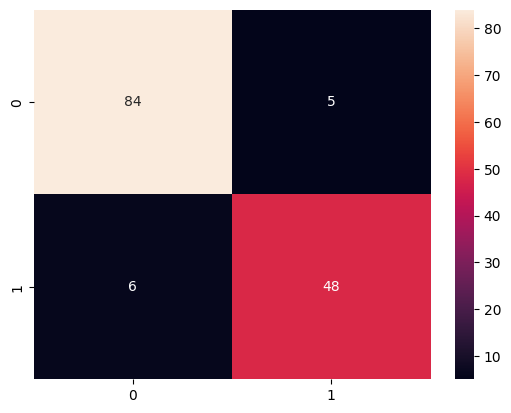

In [198]:
sns.heatmap(matrix, annot=True);

## Etapa 8: Fine-tuning dos parâmetros

In [199]:
class NeuralNetworkTuning(nn.Module):
  def __init__(self, activation, neurons, initializer):
    super().__init__()
    # 30 -> 16 -> 16 -> 1
    self.dense0 = nn.Linear(30, neurons)
    initializer(self.dense0.weight)
    self.activation0 = activation
    self.dense1 = nn.Linear(neurons, neurons)
    initializer(self.dense1.weight)
    self.activation1 = activation
    self.dense2 = nn.Linear(neurons, 1)
    initializer(self.dense2.weight)
    self.output = nn.Sigmoid()

  def forward(self, X):
    X = self.dense0(X)
    X = self.activation0(X)
    X = self.dense1(X)
    X = self.activation1(X)
    X = self.dense2(X)
    X = self.output(X)
    return X

In [200]:
classifier_tuning = NeuralNetBinaryClassifier(module=NeuralNetworkTuning,
                                                  lr = 0.001,
                                                  optimizer__weight_decay = 0.0001,
                                                  train_split=False)

In [201]:
params = {'batch_size': [10],
          'max_epochs': [100],
          'optimizer': [torch.optim.Adam, torch.optim.SGD],
          'criterion': [torch.nn.BCEWithLogitsLoss,  torch.nn.HingeEmbeddingLoss],
          'module__activation': [F.relu, F.tanh],
          'module__neurons': [8, 16],
          'module__initializer': [torch.nn.init.uniform, torch.nn.init.normal_]}

In [202]:
X = breast_cancer_dataset.data.features
X = np.array(X, dtype='float32')
X = torch.tensor(np.array(X), dtype = torch.float)


X.shape, y.shape

(torch.Size([569, 30]), torch.Size([569]))

In [203]:
grid_search = GridSearchCV(estimator=classifier_tuning, param_grid=params,
                           scoring = 'accuracy', cv = 2)
grid_search = grid_search.fit(X, y)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.9400  0.0654
      2        0.9400  0.0571
      3        0.9400  0.0567


<ipython-input-199-a66dc10cc2f9>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense0.weight)
<ipython-input-199-a66dc10cc2f9>:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense1.weight)
<ipython-input-199-a66dc10cc2f9>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense2.weight)


      4        0.9400  0.0665
      5        0.9400  0.0610
      6        0.9400  0.0636
      7        0.9400  0.0694
      8        0.9400  0.0651
      9        0.9400  0.0655
     10        0.9400  0.0678
     11        0.9400  0.0577
     12        0.9400  0.0560
     13        0.9400  0.0655
     14        0.9400  0.0716
     15        0.9400  0.0670
     16        0.9400  0.0711
     17        0.9400  0.0610
     18        0.9400  0.0594
     19        0.9400  0.0600
     20        0.9400  0.0667
     21        0.9400  0.0652
     22        0.9400  0.0710
     23        0.9400  0.0681
     24        0.9400  0.0648
     25        0.9400  0.0580
     26        0.9400  0.0470
     27        0.9400  0.0440
     28        0.9400  0.0486
     29        0.9400  0.0430
     30        0.9400  0.0504
     31        0.9400  0.0462
     32        0.8878  0.0438
     33        0.6932  0.0452
     34        0.6931  0.0428
     35        0.6931  0.0464
     36        0.6931  0.0479
     37   

<ipython-input-199-a66dc10cc2f9>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense0.weight)
<ipython-input-199-a66dc10cc2f9>:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense1.weight)
<ipython-input-199-a66dc10cc2f9>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense2.weight)


      5        0.9413  0.0456
      6        0.9413  0.0425
      7        0.9413  0.0427
      8        0.9413  0.0433
      9        0.9413  0.0417
     10        0.9413  0.0423
     11        0.9413  0.0506
     12        0.9413  0.0470
     13        0.9413  0.0445
     14        0.9413  0.0441
     15        0.9413  0.0430
     16        0.9413  0.0637
     17        0.9413  0.0682
     18        0.9413  0.0705
     19        0.9413  0.0599
     20        0.9413  0.0908
     21        0.9413  0.1062
     22        0.9413  0.1240
     23        0.9413  0.0707
     24        0.9413  0.1216
     25        0.9413  0.1250
     26        0.9413  0.1450
     27        0.9413  0.0860
     28        0.9413  0.1070
     29        0.7550  0.0830
     30        0.6931  0.0887
     31        0.6931  0.0663
     32        0.6931  0.0807
     33        0.6931  0.1345
     34        0.6931  0.1083
     35        0.6931  0.0859
     36        0.6931  0.0918
     37        0.6931  0.0698
     38   

<ipython-input-199-a66dc10cc2f9>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense0.weight)
<ipython-input-199-a66dc10cc2f9>:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense1.weight)
<ipython-input-199-a66dc10cc2f9>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense2.weight)


      4        0.9400  0.0462
      5        0.9400  0.0449
      6        0.9400  0.0482
      7        0.9400  0.0428
      8        0.9400  0.0441
      9        0.9400  0.0429
     10        0.9400  0.0443
     11        0.9400  0.0576
     12        0.9400  0.0441
     13        0.9400  0.0449
     14        0.9400  0.0432
     15        0.9400  0.0438
     16        0.9400  0.0445
     17        0.9400  0.0457
     18        0.9400  0.0489
     19        0.9400  0.0551
     20        0.9400  0.0459
     21        0.9400  0.0454
     22        0.9400  0.0490
     23        0.9400  0.0322
     24        0.9400  0.0316
     25        0.9400  0.0328
     26        0.9400  0.0329
     27        0.9400  0.0330
     28        0.9400  0.0318
     29        0.9400  0.0344
     30        0.9400  0.0329
     31        0.9400  0.0353
     32        0.9400  0.0323
     33        0.9400  0.0316
     34        0.9400  0.0335
     35        0.9400  0.0323
     36        0.9400  0.0378
     37   

<ipython-input-199-a66dc10cc2f9>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense0.weight)
<ipython-input-199-a66dc10cc2f9>:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense1.weight)
<ipython-input-199-a66dc10cc2f9>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense2.weight)


      6        0.9413  0.0377
      7        0.9413  0.0336
      8        0.9413  0.0358
      9        0.9413  0.0386
     10        0.9413  0.0356
     11        0.9413  0.0354
     12        0.9413  0.0340
     13        0.9413  0.0316
     14        0.9413  0.0325
     15        0.9413  0.0330
     16        0.9413  0.0331
     17        0.9413  0.0359
     18        0.9413  0.0329
     19        0.9413  0.0330
     20        0.9413  0.0327
     21        0.9413  0.0340
     22        0.9413  0.0326
     23        0.9413  0.0326
     24        0.9413  0.0334
     25        0.9413  0.0331
     26        0.9413  0.0353
     27        0.9413  0.0370
     28        0.9413  0.0371
     29        0.9413  0.0372
     30        0.9413  0.0342
     31        0.9413  0.0332
     32        0.9413  0.0324
     33        0.9413  0.0330
     34        0.9413  0.0337
     35        0.9413  0.0317
     36        0.9413  0.0347
     37        0.9413  0.0329
     38        0.9413  0.0392
     39   

<ipython-input-199-a66dc10cc2f9>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense0.weight)
<ipython-input-199-a66dc10cc2f9>:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense1.weight)
<ipython-input-199-a66dc10cc2f9>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense2.weight)


      5        0.9400  0.0455
      6        0.9400  0.0460
      7        0.9400  0.0443
      8        0.9400  0.0437
      9        0.9400  0.0474
     10        0.9400  0.0471
     11        0.9400  0.0464
     12        0.9400  0.0453
     13        0.9400  0.0447
     14        0.9400  0.0455
     15        0.9400  0.0439
     16        0.9400  0.0453
     17        0.9400  0.0542
     18        0.9400  0.0449
     19        0.9400  0.0440
     20        0.9400  0.0442
     21        0.9400  0.0441
     22        0.9400  0.0437
     23        0.9400  0.0439
     24        0.9400  0.0496
     25        0.9400  0.0455
     26        0.9400  0.0500
     27        0.9400  0.0457
     28        0.9400  0.0450
     29        0.9400  0.0449
     30        0.9400  0.0477
     31        0.9400  0.0437
     32        0.9400  0.0449
     33        0.9400  0.0475
     34        0.9400  0.0441
     35        0.9400  0.0454
     36        0.9400  0.0419
     37        0.9400  0.0449
     38   

<ipython-input-199-a66dc10cc2f9>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense0.weight)
<ipython-input-199-a66dc10cc2f9>:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense1.weight)
<ipython-input-199-a66dc10cc2f9>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense2.weight)


      4        0.9413  0.0622
      5        0.9413  0.0672
      6        0.9413  0.0585
      7        0.9413  0.0596
      8        0.9413  0.0638
      9        0.9413  0.0592
     10        0.9413  0.0608
     11        0.9413  0.0715
     12        0.9413  0.0474
     13        0.9413  0.0441
     14        0.9413  0.0440
     15        0.9413  0.0415
     16        0.9413  0.0435
     17        0.9413  0.0428
     18        0.9413  0.0486
     19        0.9413  0.0440
     20        0.9413  0.0439
     21        0.9413  0.0444
     22        0.9413  0.0425
     23        0.9413  0.0414
     24        0.9413  0.0464
     25        0.9413  0.0442
     26        0.9413  0.0442
     27        0.9413  0.0493
     28        0.9413  0.0480
     29        0.9413  0.0455
     30        0.9413  0.0453
     31        0.9413  0.0450
     32        0.9413  0.0477
     33        0.9413  0.0519
     34        0.9413  0.0455
     35        0.9413  0.0461
     36        0.9413  0.0443
     37   

<ipython-input-199-a66dc10cc2f9>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense0.weight)
<ipython-input-199-a66dc10cc2f9>:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense1.weight)
<ipython-input-199-a66dc10cc2f9>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense2.weight)


      6        0.9400  0.0377
      7        0.9400  0.0343
      8        0.9400  0.0333
      9        0.9400  0.0348
     10        0.9400  0.0339
     11        0.9400  0.0348
     12        0.9400  0.0374
     13        0.9400  0.0363
     14        0.9400  0.0337
     15        0.9400  0.0333
     16        0.9400  0.0320
     17        0.9400  0.0334
     18        0.9400  0.0334
     19        0.9400  0.0351
     20        0.9400  0.0341
     21        0.9400  0.0349
     22        0.9400  0.0335
     23        0.9400  0.0332
     24        0.9400  0.0332
     25        0.9400  0.0332
     26        0.9400  0.0448
     27        0.9400  0.0361
     28        0.9400  0.0368
     29        0.9400  0.0341
     30        0.9400  0.0344
     31        0.9400  0.0337
     32        0.9400  0.0339
     33        0.9400  0.0320
     34        0.9400  0.0325
     35        0.9400  0.0341
     36        0.9400  0.0334
     37        0.9400  0.0338
     38        0.9400  0.0337
     39   

<ipython-input-199-a66dc10cc2f9>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense0.weight)
<ipython-input-199-a66dc10cc2f9>:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense1.weight)
<ipython-input-199-a66dc10cc2f9>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense2.weight)


      5        0.9413  0.0435
      6        0.9413  0.0449
      7        0.9413  0.0413
      8        0.9413  0.0423
      9        0.9413  0.0413
     10        0.9413  0.0452
     11        0.9413  0.0412
     12        0.9413  0.0445
     13        0.9413  0.0452
     14        0.9413  0.0433
     15        0.9413  0.0472
     16        0.9413  0.0450
     17        0.9413  0.0441
     18        0.9413  0.0395
     19        0.9413  0.0440
     20        0.9413  0.0548
     21        0.9413  0.0513
     22        0.9413  0.0595
     23        0.9413  0.0563
     24        0.9413  0.0563
     25        0.9413  0.0532
     26        0.9413  0.0610
     27        0.9413  0.0568
     28        0.9413  0.0605
     29        0.9413  0.0590
     30        0.9413  0.0412
     31        0.9413  0.0680
     32        0.9413  0.0619
     33        0.9413  0.0446
     34        0.9413  0.0499
     35        0.9413  0.0417
     36        0.9413  0.0556
     37        0.9413  0.0408
     38   

<ipython-input-199-a66dc10cc2f9>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense0.weight)
<ipython-input-199-a66dc10cc2f9>:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense1.weight)
<ipython-input-199-a66dc10cc2f9>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense2.weight)


      5        0.9238  0.0492
      6        0.9162  0.0464
      7        0.8989  0.0444
      8        0.8563  0.0465
      9        0.7888  0.0433
     10        0.7433  0.0466
     11        0.7246  0.0444
     12        0.7161  0.0432
     13        0.7112  0.0478
     14        0.7080  0.0559
     15        0.7055  0.0669
     16        0.7036  0.0612
     17        0.7019  0.0588
     18        0.7006  0.0567
     19        0.6995  0.0621
     20        0.6987  0.0561
     21        0.6980  0.0542
     22        0.6976  0.0594
     23        0.6972  0.0548
     24        0.6969  0.0567
     25        0.6967  0.0564
     26        0.6965  0.0593
     27        0.6963  0.0529
     28        0.6962  0.0559
     29        0.6960  0.0557
     30        0.6959  0.0526
     31        0.6958  0.0602
     32        0.6957  0.0580
     33        0.6956  0.0567
     34        0.6955  0.0538
     35        0.6955  0.0544
     36        0.6954  0.0570
     37        0.6953  0.0550
     38   

<ipython-input-199-a66dc10cc2f9>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense0.weight)
<ipython-input-199-a66dc10cc2f9>:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense1.weight)
<ipython-input-199-a66dc10cc2f9>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense2.weight)


      5        0.9358  0.0491
      6        0.9324  0.0477
      7        0.9231  0.0546
      8        0.8968  0.0495
      9        0.8420  0.0462
     10        0.7797  0.0472
     11        0.7419  0.0527
     12        0.7252  0.0526
     13        0.7170  0.0493
     14        0.7122  0.0463
     15        0.7089  0.0452
     16        0.7063  0.0448
     17        0.7041  0.0437
     18        0.7024  0.0441
     19        0.7010  0.0432
     20        0.6999  0.0474
     21        0.6990  0.0449
     22        0.6984  0.0432
     23        0.6980  0.0424
     24        0.6976  0.0462
     25        0.6974  0.0432
     26        0.6971  0.0463
     27        0.6969  0.0521
     28        0.6968  0.0433
     29        0.6966  0.0458
     30        0.6964  0.0428
     31        0.6963  0.0455
     32        0.6962  0.0502
     33        0.6961  0.0448
     34        0.6960  0.0460
     35        0.6959  0.0435
     36        0.6958  0.0420
     37        0.6957  0.0509
     38   

<ipython-input-199-a66dc10cc2f9>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense0.weight)
<ipython-input-199-a66dc10cc2f9>:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense1.weight)
<ipython-input-199-a66dc10cc2f9>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense2.weight)


      6        0.9366  0.0361
      7        0.9366  0.0353
      8        0.9366  0.0317
      9        0.9365  0.0322
     10        0.9365  0.0321
     11        0.9365  0.0313
     12        0.9365  0.0307
     13        0.9365  0.0317
     14        0.9365  0.0315
     15        0.9365  0.0324
     16        0.9365  0.0342
     17        0.9365  0.0322
     18        0.9365  0.0341
     19        0.9365  0.0434
     20        0.9365  0.0389
     21        0.9365  0.0337
     22        0.9365  0.0334
     23        0.9365  0.0357
     24        0.9365  0.0333
     25        0.9365  0.0333
     26        0.9365  0.0340
     27        0.9365  0.0372
     28        0.9365  0.0397
     29        0.9365  0.0399
     30        0.9365  0.0394
     31        0.9365  0.0331
     32        0.9365  0.0328
     33        0.9365  0.0328
     34        0.9365  0.0362
     35        0.9365  0.0332
     36        0.9365  0.0338
     37        0.9365  0.0328
     38        0.9365  0.0358
     39   

<ipython-input-199-a66dc10cc2f9>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense0.weight)
<ipython-input-199-a66dc10cc2f9>:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense1.weight)
<ipython-input-199-a66dc10cc2f9>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense2.weight)


      5        0.9400  0.0434
      6        0.9400  0.0437
      7        0.9400  0.0387
      8        0.9400  0.0414
      9        0.9400  0.0464
     10        0.9400  0.0416
     11        0.9400  0.0430
     12        0.9400  0.0408
     13        0.9400  0.0402
     14        0.9400  0.0372
     15        0.9400  0.0369
     16        0.9400  0.0388
     17        0.9400  0.0393
     18        0.9400  0.0408
     19        0.9400  0.0417
     20        0.9399  0.0416
     21        0.9399  0.0401
     22        0.9399  0.0441
     23        0.9399  0.0483
     24        0.9399  0.0605
     25        0.9399  0.0461
     26        0.9399  0.0441
     27        0.9399  0.0428
     28        0.9399  0.0408
     29        0.9399  0.0472
     30        0.9399  0.0461
     31        0.9399  0.0484
     32        0.9399  0.0521
     33        0.9399  0.0440
     34        0.9399  0.0477
     35        0.9399  0.0433
     36        0.9399  0.0443
     37        0.9399  0.0433
     38   

<ipython-input-199-a66dc10cc2f9>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense0.weight)
<ipython-input-199-a66dc10cc2f9>:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense1.weight)
<ipython-input-199-a66dc10cc2f9>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense2.weight)


      5        0.9369  0.0490
      6        0.9335  0.0469
      7        0.9255  0.0453
      8        0.9066  0.0440
      9        0.8641  0.0422
     10        0.7949  0.0430
     11        0.7477  0.0447
     12        0.7281  0.0415
     13        0.7176  0.0422
     14        0.7114  0.0401
     15        0.7075  0.0422
     16        0.7043  0.0416
     17        0.7017  0.0483
     18        0.6999  0.0420
     19        0.6988  0.0458
     20        0.6982  0.0473
     21        0.6978  0.0451
     22        0.6973  0.0444
     23        0.6968  0.0454
     24        0.6962  0.0535
     25        0.6958  0.0429
     26        0.6955  0.0457
     27        0.6951  0.0448
     28        0.6947  0.0436
     29        0.6946  0.0483
     30        0.6945  0.0435
     31        0.6944  0.0446
     32        0.6944  0.0439
     33        0.6944  0.0445
     34        0.6943  0.0450
     35        0.6943  0.0489
     36        0.6943  0.0454
     37        0.6943  0.0449
     38   

<ipython-input-199-a66dc10cc2f9>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense0.weight)
<ipython-input-199-a66dc10cc2f9>:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense1.weight)
<ipython-input-199-a66dc10cc2f9>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense2.weight)


      5        0.9407  0.0517
      6        0.9400  0.0434
      7        0.9382  0.0440
      8        0.9330  0.0440
      9        0.9185  0.0419
     10        0.8828  0.0431
     11        0.8206  0.0452
     12        0.7576  0.0547
     13        0.7205  0.0425
     14        0.7062  0.0449
     15        0.7019  0.0445
     16        0.7002  0.0444
     17        0.6993  0.0465
     18        0.6985  0.0462
     19        0.6977  0.0439
     20        0.6970  0.0468
     21        0.6966  0.0439
     22        0.6964  0.0432
     23        0.6962  0.0421
     24        0.6959  0.0421
     25        0.6956  0.0432
     26        0.6951  0.0438
     27        0.6948  0.0446
     28        0.6948  0.0433
     29        0.6947  0.0443
     30        0.6946  0.0475
     31        0.6946  0.0460
     32        0.6946  0.0467
     33        0.6945  0.0428
     34        0.6945  0.0557
     35        0.6944  0.0438
     36        0.6944  0.0456
     37        0.6944  0.0478
     38   

<ipython-input-199-a66dc10cc2f9>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense0.weight)
<ipython-input-199-a66dc10cc2f9>:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense1.weight)
<ipython-input-199-a66dc10cc2f9>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense2.weight)


      5        0.9400  0.0570
      6        0.9400  0.0449
      7        0.9400  0.0447
      8        0.9400  0.0479
      9        0.9400  0.0476
     10        0.9400  0.0477
     11        0.9400  0.0634
     12        0.9400  0.0519
     13        0.9400  0.0467
     14        0.9400  0.0443
     15        0.9400  0.0454
     16        0.9400  0.0458
     17        0.9400  0.0485
     18        0.9400  0.0466
     19        0.9400  0.0460
     20        0.9400  0.0466
     21        0.9400  0.0528
     22        0.9400  0.0491
     23        0.9400  0.0486
     24        0.9400  0.0498
     25        0.9400  0.0547
     26        0.9400  0.0371
     27        0.9400  0.0354
     28        0.9400  0.0337
     29        0.9400  0.0341
     30        0.9400  0.0353
     31        0.9400  0.0373
     32        0.9400  0.0396
     33        0.9400  0.0353
     34        0.9400  0.0340
     35        0.9400  0.0331
     36        0.9400  0.0311
     37        0.9400  0.0334
     38   

<ipython-input-199-a66dc10cc2f9>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense0.weight)
<ipython-input-199-a66dc10cc2f9>:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense1.weight)
<ipython-input-199-a66dc10cc2f9>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense2.weight)


      6        0.9413  0.0380
      7        0.9413  0.0355
      8        0.9413  0.0356
      9        0.9413  0.0327
     10        0.9413  0.0326
     11        0.9413  0.0318
     12        0.9413  0.0370
     13        0.9413  0.0698
     14        0.9413  0.1502
     15        0.9413  0.1281
     16        0.9413  0.1074
     17        0.9413  0.1090
     18        0.9413  0.0361
     19        0.9413  0.0469
     20        0.9413  0.0308
     21        0.9413  0.0328
     22        0.9413  0.0336
     23        0.9413  0.0340
     24        0.9413  0.0351
     25        0.9413  0.0334
     26        0.9413  0.0334
     27        0.9413  0.0338
     28        0.9413  0.0347
     29        0.9413  0.0333
     30        0.9413  0.0337
     31        0.9413  0.0346
     32        0.9413  0.0375
     33        0.9413  0.0349
     34        0.9413  0.0328
     35        0.9413  0.0374
     36        0.9413  0.0338
     37        0.9413  0.0332
     38        0.9413  0.0329
     39   

<ipython-input-199-a66dc10cc2f9>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense0.weight)
<ipython-input-199-a66dc10cc2f9>:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense1.weight)
<ipython-input-199-a66dc10cc2f9>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  initializer(self.dense2.weight)


      5        1.0000  0.0508
      6        1.0000  0.0482
      7        1.0000  0.0560
      8        1.0000  0.0467
      9        1.0000  0.0460
     10        1.0000  0.0457
     11        1.0000  0.0476
     12        1.0000  0.0527
     13        1.0000  0.0465
     14        1.0000  0.0463
     15        1.0000  0.0467
     16        1.0000  0.0491
     17        1.0000  0.0480
     18        1.0000  0.0460
     19        1.0000  0.0450
     20        1.0000  0.0471
     21        1.0000  0.0469
     22        1.0000  0.0481
     23        1.0000  0.0473
     24        1.0000  0.0480
     25        1.0000  0.0468
     26        1.0000  0.0502
     27        1.0000  0.0509
     28        1.0000  0.0603
     29        1.0000  0.0455
     30        1.0000  0.0466
     31        0.8944  0.0484
     32        0.6268  0.0595
     33        0.6268  0.0466
     34        0.6268  0.0497
     35        0.6268  0.0490
     36        0.6268  0.0486
     37        0.6268  0.0443
     38   

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/skorch/classifier.py", line 381, in predict
    return (y_proba[:, 1] > self.threshold).astype('uint8')
IndexError: too many indi

      5        1.0000  0.0480
      6        1.0000  0.0470
      7        1.0000  0.0503
      8        1.0000  0.0476
      9        1.0000  0.0590
     10        1.0000  0.0497
     11        1.0000  0.0495
     12        1.0000  0.0501
     13        1.0000  0.0490
     14        1.0000  0.0486
     15        1.0000  0.0503
     16        1.0000  0.0482
     17        1.0000  0.0465
     18        1.0000  0.0532
     19        1.0000  0.0475
     20        1.0000  0.0506
     21        1.0000  0.0469
     22        1.0000  0.0455
     23        1.0000  0.0460
     24        1.0000  0.0468
     25        1.0000  0.0454
     26        1.0000  0.0592
     27        1.0000  0.0622
     28        1.0000  0.0659
     29        1.0000  0.0734
     30        1.0000  0.0713
     31        1.0000  0.0664
     32        1.0000  0.0622
     33        1.0000  0.0594
     34        1.0000  0.0612
     35        1.0000  0.0644
     36        1.0000  0.0616
     37        1.0000  0.0573
     38   

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.4975661  0.37258463 0.53616259 0.37258463 0.50266247 0.49934519
 0.62566098 0.37258463 0.37258463 0.37258463 0.37258463 0.37258463
 0.37258463 0.37258463 0.37258463 0.37258463        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
  warnings.warn(


      3        0.9407  0.1003
      4        0.9407  0.0804
      5        0.9407  0.0944
      6        0.9407  0.0822
      7        0.9407  0.0854
      8        0.9407  0.0838
      9        0.9407  0.0843
     10        0.9407  0.0896
     11        0.9407  0.0850
     12        0.9407  0.0853
     13        0.9407  0.0873
     14        0.9407  0.0842
     15        0.9407  0.0850
     16        0.9407  0.0844
     17        0.9407  0.0944
     18        0.9407  0.0831
     19        0.9407  0.0857
     20        0.9407  0.0934
     21        0.9407  0.0881
     22        0.9407  0.0910
     23        0.9407  0.0836
     24        0.9407  0.0907
     25        0.9407  0.1007
     26        0.9407  0.0845
     27        0.9407  0.0847
     28        0.9407  0.0935
     29        0.9407  0.0824
     30        0.9407  0.0866
     31        0.9407  0.0876
     32        0.9407  0.0835
     33        0.9407  0.0883
     34        0.9407  0.0873
     35        0.9407  0.0876
     36   

In [204]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [207]:
best_params

{'batch_size': 10,
 'criterion': torch.nn.modules.loss.BCEWithLogitsLoss,
 'max_epochs': 100,
 'module__activation': <function torch.nn.functional.relu(input: torch.Tensor, inplace: bool = False) -> torch.Tensor>,
 'module__initializer': <function torch.nn.init.normal_(tensor: torch.Tensor, mean: float = 0.0, std: float = 1.0, generator: Optional[torch._C.Generator] = None) -> torch.Tensor>,
 'module__neurons': 16,
 'optimizer': torch.optim.adam.Adam}

In [ ]:
best_score